In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation period
tmax = 50           # For the analytical solution (a)

# Well setup
a = 450             # Half the distance between the wells (m)
Q = 0.03            # Injection rate (m³/s)

# Rock
M = 30              # Vertical extent of the aquifer (m)
phi = 0.4           # Porosity (-) 
rho_S = 1900        # Density (kg/m³)
c_S = 850           # Specific heat capacity (J/(kg*K))
lambda_S = 3.0      # Thermal conductivity (W/(m*K))

# Fluid
rho_F = 1500        # Density (kg/m³)
c_F = 4200          # Specific heat capacity (J/(kg*K))

# Numerical model
diameter = 4000     # Diameter of the domain (m)
#dwell = 0.3        # Diameter of the wells (m)
dwell = 50
Tin = 1.0           # Injection temperature (A.U.)
Tref = 0.0          # Reference temperature = normalized initial reservoir temperature (A.U.)
lc = diameter / 10  # Reference mesh size for gmsh mesh generator

#dM = 1             # Vertical distance between well and aquitard (m)
#L0 = 0.01          # Vertical element size in the aquitard
                    # at the interface between aquifer and aquitard (m)

seconds_per_year = 60*60*24*365     # Conversion factor 

## Characterization of the system
# Thermal breakthrough at extraction well 
rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
G = rho_A_c_A / (rho_F * c_F)
tb = G * 4 * np.pi * M * a * a / (3 * Q) / seconds_per_year
print(f"The thermal breaktrough at the extraction well is {tb:.2f} years.")

# Affected thickness of the aquitard from (thermal) diffusion length
L = np.sqrt(2 * tmax * seconds_per_year * lambda_S / rho_A_c_A)
print(f"The affected zone within the aquitard spans {L:.2f} meters in thickness.")

The thermal breaktrough at the extraction well is 14.90 years.
The affected zone within the aquitard spans 52.07 meters in thickness.


Note: the solution for heat transfer does not consider heat exchange with the aquitard.


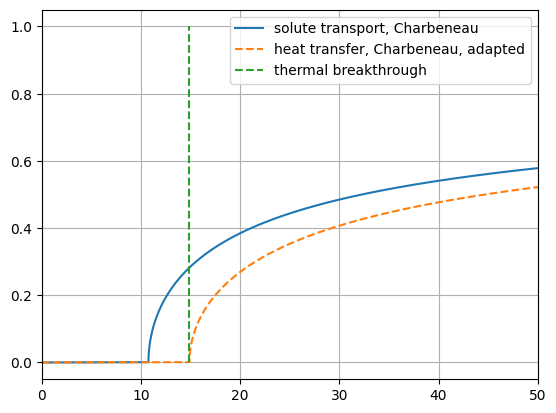

In [ ]:
F = np.linspace(1e-20, 1, 1000)
tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / seconds_per_year
tau = G*tf/phi

print("Note: the solution for heat transfer does not consider heat exchange with the aquitard.")

plt.plot(tf, F, label="solute transport, Charbeneau")
plt.plot(tau, F, '--', label="heat transfer, Charbeneau, adapted")
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")

plt.grid()
plt.xlim((0, tmax))
plt.legend()
plt.show()

Der Befehl "pip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "pip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "pip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "pip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


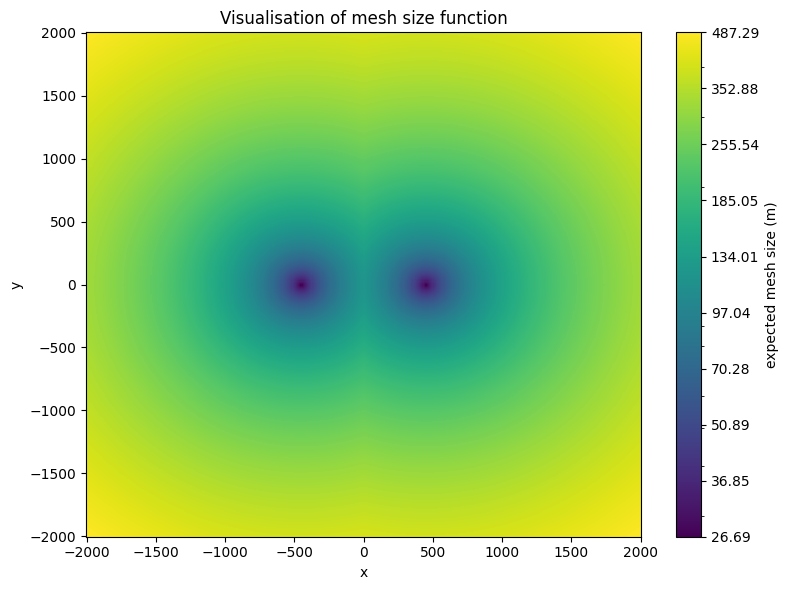

In [10]:
#Install gmsh without X11 dependency
!pip uninstall -y pygmsh 
!pip uninstall -y gmsh
!pip install -i https://gmsh.info/python-packages-dev-nox --force-reinstall --no-cache-dir gmsh==4.15.0.dev1+nox
# Fixed gmsh version due to problems of gmsh 5.0.0 with pygmsh
!pip install pygmsh 

import pygmsh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# functions for mesh size 

def field(x, y, d):
    return 0.4*np.power(np.sqrt((x+d)*(x+d) + y*y), 0.9)+dwell/2

def doublet(x, y, d):
    return np.minimum(field(x, y, -d), field(x, y, d))

# plot with logarithmic color scale

x_range = np.linspace(-diameter/2, diameter/2, 500)
y_range = np.linspace(-diameter/2, diameter/2, 500)
X, Y = np.meshgrid(x_range, y_range)
Z = doublet(X, Y, d=a) # evaluate mesh size function for plot
z_min = np.min(Z)
z_max = np.max(Z)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto', norm=LogNorm(vmin=z_min, vmax=z_max), cmap='viridis')
cbar = plt.colorbar(label='expected mesh size (m)')
plt.title('Visualisation of mesh size function')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

ticks = np.geomspace(z_min, z_max, 10) # ticks for colorbar 
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])

plt.show()

c:\Users\jante\Anaconda3\envs\python_310\lib\site-packages\pygmsh\occ\geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean difference operation.
  warnings.warn(
c:\Users\jante\Anaconda3\envs\python_310\lib\site-packages\pygmsh\occ\geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 2> discarded in Boolean difference operation.
  warnings.warn(


Widget(value='<iframe src="http://localhost:51667/index.html?ui=P_0x2341637f3a0_0&reconnect=auto" class="pyvis…

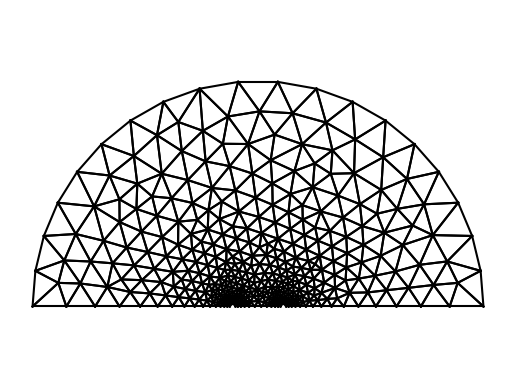

In [11]:
#!pip install pyvista[jupyter]
import pyvista as pv
#pv.set_jupyter_backend('trame')

with pygmsh.occ.Geometry() as geom:

    # Disk as base geometry for domain
    disk_domain = geom.add_disk([0.0, 0.0], diameter, mesh_size=lc)

    # Add injection and extraction well as holes in the geometry
    for b in [-a, a]:
        disk_well = geom.add_disk([b, 0.0], dwell, mesh_size=dwell/2)
        geom.boolean_difference(disk_domain, disk_well)

    # Remove half of the domain because of symmetry
    rectangle = [geom.add_rectangle([-diameter, -diameter, 0.0], 2*diameter, diameter)]
    geom.boolean_difference(disk_domain, rectangle)

    # Define local mesh size
    geom.set_mesh_size_callback(
        lambda dim, tag, x, y, z, lc: doublet(x,y,a)
    )

    # Generate mesh
    mesh = geom.generate_mesh()

mesh.write("domain.vtu")

# Plot mesh with Pyvista
plotter = pv.Plotter()
plotter.add_mesh(mesh, show_edges=True)
plotter.view_xy()
plotter.show()

#Alternative plot without Pyvista
triangles = mesh.cells_dict["triangle"]
points = mesh.points

pts = points[:, :2]
for e in triangles:
    for idx in [[0, 1], [1, 2], [2, 0]]:
        X = pts[e[idx]]
        plt.plot(X[:, 0], X[:, 1], "-k")

plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
plt.show()

In [12]:
from geo import layersfromsurf

scenario = 1


if scenario == 1:
    nAquifer = 1

elif scenario == 2:
    nAquifer = 3
    nAquitard = 5

    phiAquitard = 0.1
    KAquitard = 1e-14

KAquifer = 1e-10


for file in ["domain.vtu"]:

    mesh2d = pv.read(file)

    if scenario == 1:
        thickness = np.array([M])

    elif scenario == 2:
        pAquitard = np.geomspace(L0, L, nAquitard+2)
        dAquitard = np.diff(pAquitard)
        thickness = np.hstack((np.flip(dAquitard), 
                            np.array([dM]),
                            np.array([(M-dM)/2/nAquifer] * nAquifer)))

    mesh3d = layersfromsurf(mesh2d, thickness)

    mesh3d["porosity"] = np.repeat(phi, mesh3d.number_of_cells)
    mesh3d["permeability"] = np.repeat(KAquifer, mesh3d.number_of_cells)

    if scenario == 2:
        mesh3d["porosity"][mesh3d["Layer"] <= nAquitard] = phiAquitard
        mesh3d["permeability"][mesh3d["Layer"] <= nAquitard] = KAquifer 

    #mesh3d["Porosity"][mesh3d["Layer"] > (nAquitard+nAquifer)] = phiAquitard
    #mesh3d["Permeability"][mesh3d["Layer"] > (nAquitard+nAquifer)] = KAquitard

    # Add info for OGS
    mesh3d.point_data["bulk_node_ids"] = np.arange(0, mesh3d.n_points, dtype=np.uint64)
    mesh3d.cell_data["bulk_element_ids"] = np.arange(0, mesh3d.n_cells, dtype=np.uint64)

    mesh3d.save(file)


#mesh3d.plot(scalars="Layer", show_edges=True, cmap="viridis")
#mesh3d.plot(scalars="porosity", show_edges=True, cmap="Pastel1")

In [13]:
surf = mesh3d.extract_surface()
cell_normals = surf.cell_normals

# Define surface normals and names
n_vectors = [[0, 0, -1], [0, 0, 1], [0, 1, 0]]
surf_names = ["bottom", "top", "profile"]
eps = 1e-8

#all_selected = np.array([], dtype=int)
all_selected = np.array([])

# Select surface cells based on normal vectors
for n, name in zip(n_vectors, surf_names):
    l2 = np.linalg.norm(cell_normals - n, axis=1)
    ids = np.where(l2 < eps)[0]

    if ids.size > 0:
        subset = surf.extract_cells(ids)
        subset.save(f"{name}.vtu")
        all_selected = np.concatenate((all_selected, ids))
        print(f"{name}: {ids.size} cells found...")
    else:
        print(f"Warning: {name} mesh has no cells...")

# Identify unselected surface cells
unselected_ids = np.setdiff1d(np.arange(surf.n_cells), all_selected)
unselected = surf.extract_cells(unselected_ids)
centers = unselected.cell_centers().points[:,:2] #ignore z-value

# Define classification centers and names
radius = 5*dwell
targets = [[b, 0], [-b, 0]]
names = ["injection", "extraction"]

classified_ids = np.array([], dtype=int)

# Classify injection and extraction cells by distance
for pt, name in zip(targets, names):
    dist = np.linalg.norm(centers - np.array(pt), axis=1)
    ids = np.where(dist < radius)[0]

    if ids.size > 0:
        subset = unselected.extract_cells(ids)
        subset.save(f"{name}.vtu")
        classified_ids = np.concatenate((classified_ids, ids))
        print(f"{name}: {ids.size} cells found...")
    else:
        print(f"Warning: {name} mesh has no cells...")

# Remaining cells are boundary
boundary_ids = np.setdiff1d(np.arange(unselected.n_cells), classified_ids)
if boundary_ids.size > 0:
    unselected.extract_cells(boundary_ids).save("boundary.vtu")
    print(f"boundary: {boundary_ids.size} cells found...")
else:
    print("Warning: boundary mesh has no cells...")     

bottom: 718 cells found...
top: 718 cells found...
profile: 43 cells found...
injection: 4 cells found...
extraction: 4 cells found...
boundary: 19 cells found...


In [14]:
import ogstools as ogs

mesh2d = pv.read("injection.vtu")
#mesh2d.plot(show_edges=True, cmap="Pastel1")

# Calculate surface area
surface_area = mesh2d.area
print(f"The discretized surface area is: {surface_area:.2f} m²")
print(f"The real surface area is: {dwell*np.pi*M:.2f} m²")

# Calculate inflow rates at injection well
qVin = Q / surface_area / 2                  # Pressure
qTin = rho_F * c_F * qVin * (Tin - Tref)    # Temperature

# Define injection rate for source term at injection well (pressure)
prj_file = r"doublet.prj"
prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.replace_parameter_value(name="injection_rate", value=qVin)
prj.replace_parameter_value(name="heatinjection", value=qTin)
prj.write_input() 

ModuleNotFoundError: No module named 'ogstools'

In [ ]:
mesh2d = pv.read("extraction.vtu")
#mesh2d.plot(show_edges=True, cmap="Pastel1")

# Calculate surface area
surface_area = mesh2d.area
print(f"The surface area is: {surface_area:.2f} m²")

# Calculate outflow rates at extraction well
qVout = - qVin
qTout = 0

# Write parameter for Python sink term for temperatur at extraction well
with open("parameter.py", "w", encoding="utf-8") as file:
    file.write(f"Area = {surface_area}")

# Define extraction_rate for sink term (pressure) at extraction well
prj_file = r"doublet.prj"
prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.replace_parameter_value(name="extraction_rate", value=qVout)
prj.write_input()

The surface area is: 3708.20 m²


In [ ]:
# Add bulk_node_ids with OGSTools

!identifySubdomains -m domain.vtu -- extraction.vtu
!identifySubdomains -m domain.vtu -- injection.vtu
!identifySubdomains -m domain.vtu -- top.vtu
!identifySubdomains -m domain.vtu -- bottom.vtu
!identifySubdomains -m domain.vtu -- boundary.vtu
!identifySubdomains -m domain.vtu -- profile.vtu

[2025-11-04 16:45:17.178] [ogs] [info] Mesh reading time: 0.0036408 s
[2025-11-04 16:45:17.179] [ogs] [info] MeshNodeSearcher construction time: 0.000186408 s
[2025-11-04 16:45:17.179] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1.6951e-05 s
[2025-11-04 16:45:17.179] [ogs] [info] There is already a 'bulk_node_ids' property present in the subdomain mesh 'extraction' and it is equal to the newly computed values.
[2025-11-04 16:45:17.182] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.00330287 s
[2025-11-04 16:45:17.182] [ogs] [info] There is already a 'bulk_element_ids' property present in the subdomain mesh 'extraction' and it is equal to the newly computed values.
[2025-11-04 16:45:17.182] [ogs] [info] identifySubdomains time: 0.00337773 s
[2025-11-04 16:45:17.184] [ogs] [info] writing time: 0.00209561 s
[2025-11-04 16:45:17.184] [ogs] [info] Entire run time: 0.00958157 s
[2025-11-04 16:45:17.385] [ogs] [info] Mesh reading time: 0.0

In [ ]:
!NodeReordering -i domain.vtu -o domain.vtu
!checkMesh -v domain.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v injection.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v extraction.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v boundary.vtu

[2025-11-04 16:45:18.384] [ogs] [info] Reordering nodes... 
[2025-11-04 16:45:18.384] [ogs] [info] Corrected 718 elements.
[2025-11-04 16:45:18.387] [ogs] [info] VTU file written.
[2025-11-04 16:45:18.572] [ogs] [info] Memory size: 0 MiB
[2025-11-04 16:45:18.572] [ogs] [info] Time for reading: 0.00425674 s
[2025-11-04 16:45:18.572] [ogs] [info] Axis aligned bounding box: 	x [-4000, 4000) (extent 8000)
	y [-1.44023e-12, 3984.48) (extent 3984.48)
	z [0, 30) (extent 30)
[2025-11-04 16:45:18.572] [ogs] [info] Min/max edge lengths: [29.9665, 748.905]
[2025-11-04 16:45:18.572] [ogs] [info] Number of elements in the mesh:
[2025-11-04 16:45:18.572] [ogs] [info] 	Prisms: 718
[2025-11-04 16:45:18.572] [ogs] [info] Mesh Quality Control:
[2025-11-04 16:45:18.572] [ogs] [info] Looking for unused nodes...
[2025-11-04 16:45:18.572] [ogs] [info] Found 0 potentially collapsible nodes.
[2025-11-04 16:45:18.573] [ogs] [info] Testing mesh element geometry:
[2025-11-04 16:45:18.573] [ogs] [info] No errors 

In [ ]:
import ogstools as ogs

prj_file = r"doublet.prj"
prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.run_model()

Project file written to output.
Simulation: doublet.prj
Status: finished successfully.
Execution took 346.946977853775 s


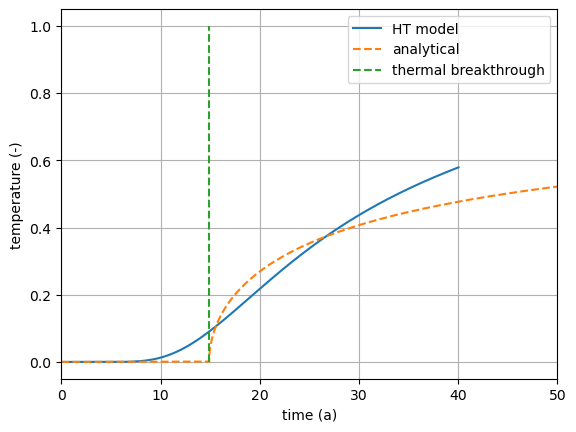

In [ ]:
from helper import mean_over_time
import matplotlib.pyplot as plt

time, temperature = mean_over_time("geothermal_doublet.pvd", "domain.vtu", "extraction.vtu", "temperature")
seconds_per_year = 60*60*24*365

plt.plot(time/seconds_per_year, temperature, label="HT model")
plt.plot(tau, F, '--', label="analytical")
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")
plt.xlabel("time (a)")
plt.ylabel("temperature (-)")
plt.grid()
plt.xlim((0, tmax))
plt.legend()
plt.show()